In [83]:
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt

In [154]:
def psd(s, nfft, scaling, fs, window): 
    reshape = np.reshape(s[0:nfft*(np.size(s)//nfft)], (np.size(s)//nfft, nfft)) * window(nfft)
    spectrum = np.abs(np.fft.fft(reshape, axis = 1))**2 / nfft**2
    spectrum *= nfft/np.sum(window(nfft)**2)
    average = np.mean(spectrum, axis = 0)
    if scaling == "density":
        return average / (fs/nfft)
    elif scaling == "spectrum":
        return average 

In [263]:
dB = lambda v: 10*np.log10(v)

# Constants
k = 1.380649e-23 # J/K
T = 300 # K
N0 = k*T # dB-Hz

# Parameters
t = 10 # s
fs = int(1e6) # Hz
fc = fs/8 # Hz
nfft = 512 # check influence
p_noise = N0*fs # W
p_sig = 1e-15 # W
sigma = np.sqrt(p_noise) # sqrt(W)
n = t * fs

# Signals
noise = (sigma / np.sqrt(2)) * (np.random.randn(n) + 1j*np.random.randn(n))
spur = np.sqrt(p_sig)*np.exp(2j*np.pi*fc*np.arange(0, t, 1/fs)*(1+np.arange(0, t, 1/fs)/40))
signal = spur + noise

In [264]:
def hitmap(s, nfft, window):
    rows = 512
    hitmap = np.zeros((rows, nfft))
    reshape = np.reshape(s[0:nfft*(np.size(s)//nfft)], (np.size(s)//nfft, nfft)) * window(nfft)
    spectrum = np.abs(np.fft.fft(reshape, axis = 1))**2 / nfft**2
    spectrum *= nfft/np.sum(window(nfft)**2)
    spectrum = dB(spectrum)
    spectrum -= np.min(spectrum)
    vmax = np.max(spectrum)
    for spec in spectrum:
        for i, v in enumerate(spec):
            hitmap[int(rows*v/vmax) - 1, i] += 1
    return hitmap

hit = hitmap(signal, 512, np.ones)[::-1, :]

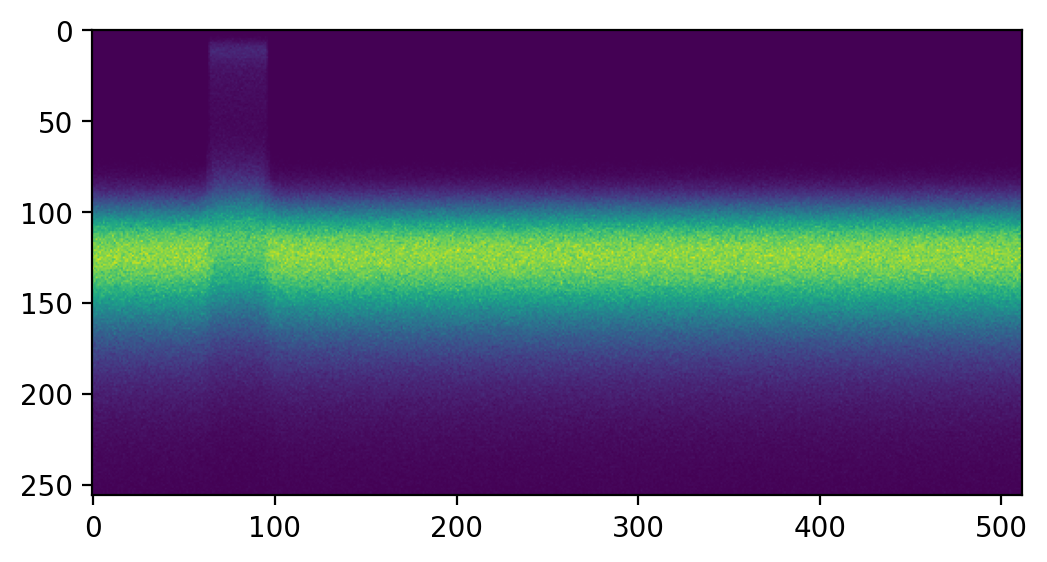

In [265]:
plt.figure(dpi=200)
plt.imshow(hit[0:256, :])

In [244]:
N0_bin = dB(np.var(noise)/nfft)
N0_hz = dB(np.var(noise)/fs)
C = dB(np.var(spur))

print(f'P_noise (dBW) =  {dB(np.var(noise)):.3f}')
print(f'N0 (dBW/bin) =  {N0_bin:.3f}')
print(f'N0 (dBW/Hz) =  {N0_hz:.3f}')
print(f'P_spur (dBW) =  {dB(np.var(spur)):.3f}')
print(f'C (dBW) =  {C:.3f}')
print(f'SNR (dB) =  {dB(np.var(spur)) - dB(np.var(noise)):.3f}')
print(f'C/N0 (dB-Hz) =  {C - N0_bin:.3f}')

# Cross check with scipy welch

f_density, psd_welch_density = scipy.signal.welch(signal, nperseg = nfft, noverlap = 0, scaling = "density", window = 'rect', fs = fs)
f_spectrum, psd_welch_spectrum = scipy.signal.welch(signal, nperseg = nfft, noverlap = 0, scaling = "spectrum", window = 'rect', fs = fs)
psd_custom_density = psd(signal, nfft, "density", fs, np.ones) # V**2/Hz
psd_custom_spectrum = psd(signal, nfft, "spectrum", fs, np.ones) # V**2

print(f"PSD WELCH DENSITY : {dB(np.sum(psd_welch_density)*fs/nfft)}")
print(f"PSD CUSTOM DENSITY : {dB(np.sum(psd_custom_density)*fs/nfft)}")
print(f"PSD WELCH SPECTRUM : {dB(np.sum(psd_welch_spectrum))}")
print(f"PSD CUSTOM SPECTRUM : {dB(np.sum(psd_custom_spectrum))}")

P_noise (dBW) =  -143.826
N0 (dBW/bin) =  -170.919
N0 (dBW/Hz) =  -203.826
P_spur (dBW) =  -150.000
C (dBW) =  -150.000
SNR (dB) =  -6.174
C/N0 (dB-Hz) =  20.919
PSD WELCH DENSITY : -142.89252210758107
PSD CUSTOM DENSITY : -142.88558819765078
PSD WELCH SPECTRUM : -142.89252210758107
PSD CUSTOM SPECTRUM : -142.88558819765078


Text(0.5, 1.0, 'PSD (Density)')

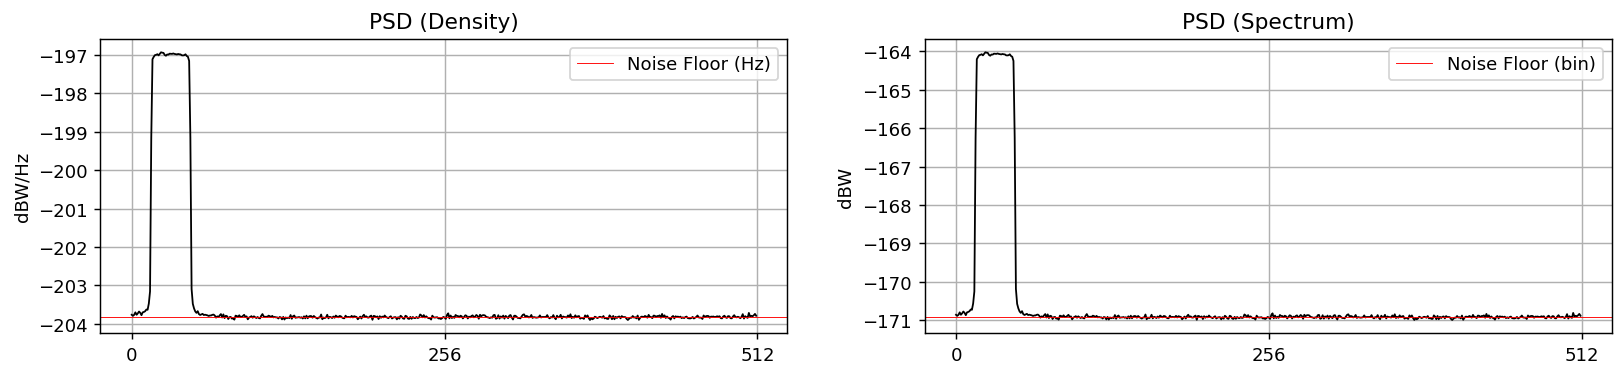

In [245]:
s = signal
plt.figure(dpi=130, figsize = (15, 3))

plt.subplot(1, 2, 2)
plt.plot(dB(psd(s, nfft, "spectrum", fs, np.ones)), linewidth = 1, c = "k")
plt.xticks(np.arange(0, nfft+256, 256));
plt.axhline(y=dB(np.var(noise)/nfft), c = 'red', label = 'Noise Floor (bin)', linewidth = 0.5)
plt.ylabel("dBW")
plt.legend()
plt.grid()
plt.title('PSD (Spectrum)')

plt.subplot(1, 2, 1)
plt.plot(dB(psd(s, nfft, "density", fs, np.ones)), linewidth = 1, c = "k")
plt.xticks(np.arange(0, nfft+256, 256));
plt.axhline(y=dB(np.var(noise)/fs), c = 'red', label = 'Noise Floor (Hz)', linewidth = 0.5)
plt.ylabel("dBW/Hz")
plt.legend()
plt.grid()
plt.title('PSD (Density)')